In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d

In [2]:
# Set figure parameters for all plots
newParams = {'figure.figsize'  : (7, 6),  # Figure size
             'figure.dpi'      : 200,      # figure resolution
             'axes.titlesize'  : 7,       # fontsize of title
             'axes.labelsize'  : 5,       # fontsize of axes labels
             'axes.linewidth'  : 1,        # width of the figure box lines
             'lines.linewidth' : 1,        # width of the plotted lines
             'savefig.dpi'     : 200,      # resolution of a figured saved using plt.savefig(filename)
             'ytick.labelsize' : 5,       # fontsize of tick labels on y axis
             'xtick.labelsize' : 5,       # fontsize of tick labels on x axis
             'legend.fontsize' : 5,       # fontsize of labels in legend
             'legend.frameon'  : True,     # activate frame on lengend?
            }
plt.rcParams.update(newParams) # Set new plotting parameters

In [3]:
# Implementing the drag function
def drag(v_):
  """
  Function that incorporates a quadratic term as a drag
  Parameters
  ----------
  v_ : Float
        Value of v
  g : Float
        Value of g
  """
  return gamma1*np.square(v_) + gamma2*np.power(v_,1) - g

# Implementing of Euler Solver
def euler_drag(f,t0: float,tN: float, N: int)->tuple:
      """
      Euler Implementation:
      Parameters
      ----------
      f : Function
            Quadradic drag function
      t0 : Float
            Initial time
      tN : Float
            Final time
      N : Integer
            Number of steps
      """
      t = np.linspace(t0, tN, N)
      v    = np.zeros([N])
      y    = np.zeros([N])
      h = (tN-t0)/N
      for i in range(1,N):
            v[i] = v[i-1] + h*f(v[i-1])
            y[i] = y[i-1] + h*v[i]
      return t, y, v

# Implementing Runge-Kutta Solver
def rk4_drag(f,t0,tN, N):
  """
  Runge-Kutta Implementation:
  Parameters
  ----------
  f : Function
        Quadradic drag function

  t0 : Float
        Initial time
  tN : Float
        Final time
  N : Integer
        Number of steps
  """
  t = np.linspace(t0, tN, N)
  v = np.zeros(N)
  y = np.zeros(N)
  h = (tN-t0)/N
  for n in range(1,N):
    k1 = h*f(v[n-1]       )
    k2 = h*f(v[n-1] + k1/2)
    k3 = h*f(v[n-1] + k2/2)
    k4 = h*f(v[n-1] + k3  )

    v[n] = v[n-1] + (k1 + 2*k2 + 2*k3 + k4)/6
    y[n] = y[n-1] + v[n]*h
  return t, y, v

def adaptive_drag(f, t0:float, tN:float, h_initial:float, eps=1e-3, h_min=1e-4, h_max=1.0) -> tuple:
      """
      Adaptive step size Runge-Kutta solver for a first order ODE
      Parameters
      ----------
      f : Function
              Quadradic drag function
      t0 : Float
              Initial time
      tN : Float
                  Final time
      h_initial : Float
                  Initial step size
      eps : Float
                  Error tolerance
      h_min : Float
                  Minimum step size
      h_max : Float
                  Maximum step size
      """
      t = [t0]
      v = [0]  # Initial condition v(t0) = 0
      y = [0]  # Initial condition y(t0) = 0
      h = h_initial
      while t[-1] < tN:
            v_current = v[-1]
            t_current = t[-1]

            # Midpoint Rule (2nd order RK)
            k1 = f(v_current)
            k2 = f(v_current + h/2 * k1)
            v_next = v_current + h * k2

            # Error Estimation (using embedded Euler step)
            v_euler = v_current + h * k1  # Simple Euler step
            error = abs(v_next - v_euler)

            # Step Size Adjustment
            if error < eps:
                  t.append(t_current + h)
                  v.append(v_next)
                  y.append(y[-1] + v_next*h) # Updating y position
                  h = min(h * 1.2, h_max)  # Increase step size slightly
            else:
                  h = max(h * 0.5, h_min)  # Decrease step size

            # if h < h_min:
            #     raise ValueError("Step size too small. Consider reducing tolerance or increasing h_min.")

      return np.array(t), np.array(y), np.array(v)

In [4]:
def energy(mass_, y_, v_):
  """
  Function calculates the total energy over a trajectory
  Parameters
  ----------
  mass_ : Float
        Value of mass
  y_: Float
        Value of y
  v_ : Float
        Value of v

  """
  return np.abs(.5*mass_*np.square(v_) + mass_*g*y_)


def momentum(mass_, v_):
  """
  Function calculates the total energy over a trajectory
  Parameters
  ----------
  mass_ : Float
        Value of mass
  v_ : Float
        Value of v

  """
  return np.abs(mass_*v_)

In [5]:
# Implementing the interpolation function

def interp_func(t_, y_):
  """
  Function that interpolates position function and takes the time derivative, returning the velocity
  Parameters
  ----------
  t_ : Float
        Value of t
  y_ : Float
        Value of y
  """
  position_spline = UnivariateSpline(t_, y_, k=3)
  velocity_function = position_spline.derivative()
  time_points = np.linspace(t0, tf, 50)
  velocities = velocity_function(time_points)
  positions=position_spline(time_points)

  #test point
  time_point = 0.4
  position_at_time_point = position_spline(time_point)

  return time_points, positions-positions[0], velocities-velocities[0], position_at_time_point

In [6]:
# Retrieve Experimental Data
tdata,xdata,ydata,vxdata,vydata = np.loadtxt("tennis1.txt", unpack=True)

# Normalize data
tdata  = tdata-tdata[0]
xdata  = -(xdata-xdata[0])
vxdata = vxdata-vxdata[0]

# Error bands for trial1
xdata_upr = xdata + .03
xdata_lwr = xdata - .03

In [7]:
# Retrieve PINN data
pinn_data = np.loadtxt('pinn_data.txt', delimiter=',', skiprows=1)

In [8]:
# Define Global Parameters
g     = 9.8                       # gravity
c_d   = .6                        # cd of tennis ball
rho   = 1.                        # density
area  = 3.25*10**-3               # cross sectional area of tennis ball in m^2
mass  = 58 *10**-3                # mass of tennis ball in kg
# gamma = .5*(1/mass)*rho*area*c_d  # drag coefficient

gamma1 = .1
gamma2 = 1

# Time interval
t0 = 0.00
tf = 0.44

# Number of steps
N  = 50

In [9]:
#Energy and momentum for trial1
E_trial1=energy(mass,xdata,vxdata)
P_trial1=momentum(mass,vxdata)

In [10]:
# Euler Solution
euler_solver = euler_drag(drag, t0, tf, N)
E_euler=energy(mass,euler_solver[1],euler_solver[2])
print(euler_solver[1])
P_euler=momentum(mass,euler_solver[2])

[ 0.00000000e+00 -7.58912000e-04 -2.28335683e-03 -4.57989638e-03
 -7.65503007e-03 -1.15151913e-02 -1.61667439e-02 -2.16159784e-02
 -2.78691088e-02 -3.49322685e-02 -4.28115072e-02 -5.15127870e-02
 -6.10419789e-02 -7.14048591e-02 -8.26071057e-02 -9.46542950e-02
 -1.07551898e-01 -1.21305277e-01 -1.35919683e-01 -1.51400249e-01
 -1.67751991e-01 -1.84979803e-01 -2.03088451e-01 -2.22082576e-01
 -2.41966683e-01 -2.62745144e-01 -2.84422194e-01 -3.07001924e-01
 -3.30488283e-01 -3.54885073e-01 -3.80195947e-01 -4.06424404e-01
 -4.33573791e-01 -4.61647295e-01 -4.90647946e-01 -5.20578611e-01
 -5.51441993e-01 -5.83240631e-01 -6.15976893e-01 -6.49652979e-01
 -6.84270920e-01 -7.19832570e-01 -7.56339611e-01 -7.93793550e-01
 -8.32195716e-01 -8.71547261e-01 -9.11849156e-01 -9.53102196e-01
 -9.95306994e-01 -1.03846398e+00]


In [11]:
# Runge-Kutta Solution
rk4_solver = rk4_drag(drag,t0,tf, N)
E_rk4=energy(mass,rk4_solver[1],rk4_solver[2])
P_rk4=momentum(mass,rk4_solver[2])

In [12]:
# Adaptative Step Size Solution
h_initial = 0.1 #initial step size
adapt_solver = adaptive_drag(drag, t0, tf, h_initial)
E_adapt=energy(mass,adapt_solver[1],adapt_solver[2])
P_adapt=momentum(mass,adapt_solver[2])

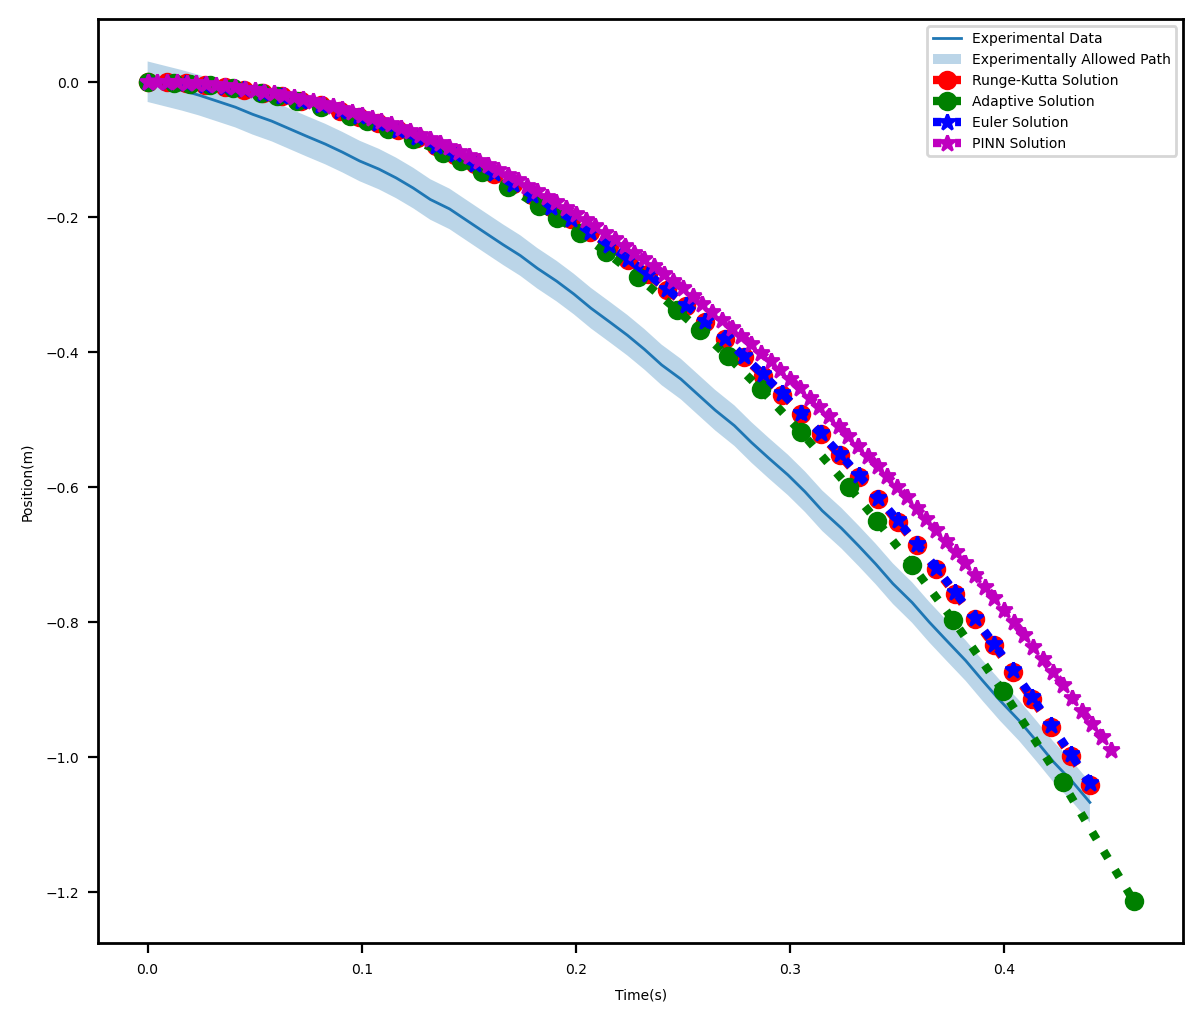

In [13]:
#plotting position
plt.plot(tdata,xdata, label=r'Experimental Data')
plt.fill_between(tdata, xdata_upr, xdata_lwr,    alpha=0.3,    label="Experimentally Allowed Path")
plt.plot(rk4_solver[0],rk4_solver[1],    ':ro' , linewidth=3.0,label=r'Runge-Kutta Solution')
plt.plot(adapt_solver[0],adapt_solver[1],':go' , linewidth=3.0,label=r'Adaptive Solution')
plt.plot(euler_solver[0],euler_solver[1],':b*' , linewidth=3.0,label=r'Euler Solution')
plt.plot(pinn_data[:,0],-pinn_data[:,1],':m*' , linewidth=3.0,label=r'PINN Solution')
plt.xlabel('Time(s)')
plt.ylabel('Position(m)')
plt.legend()
plt.show()

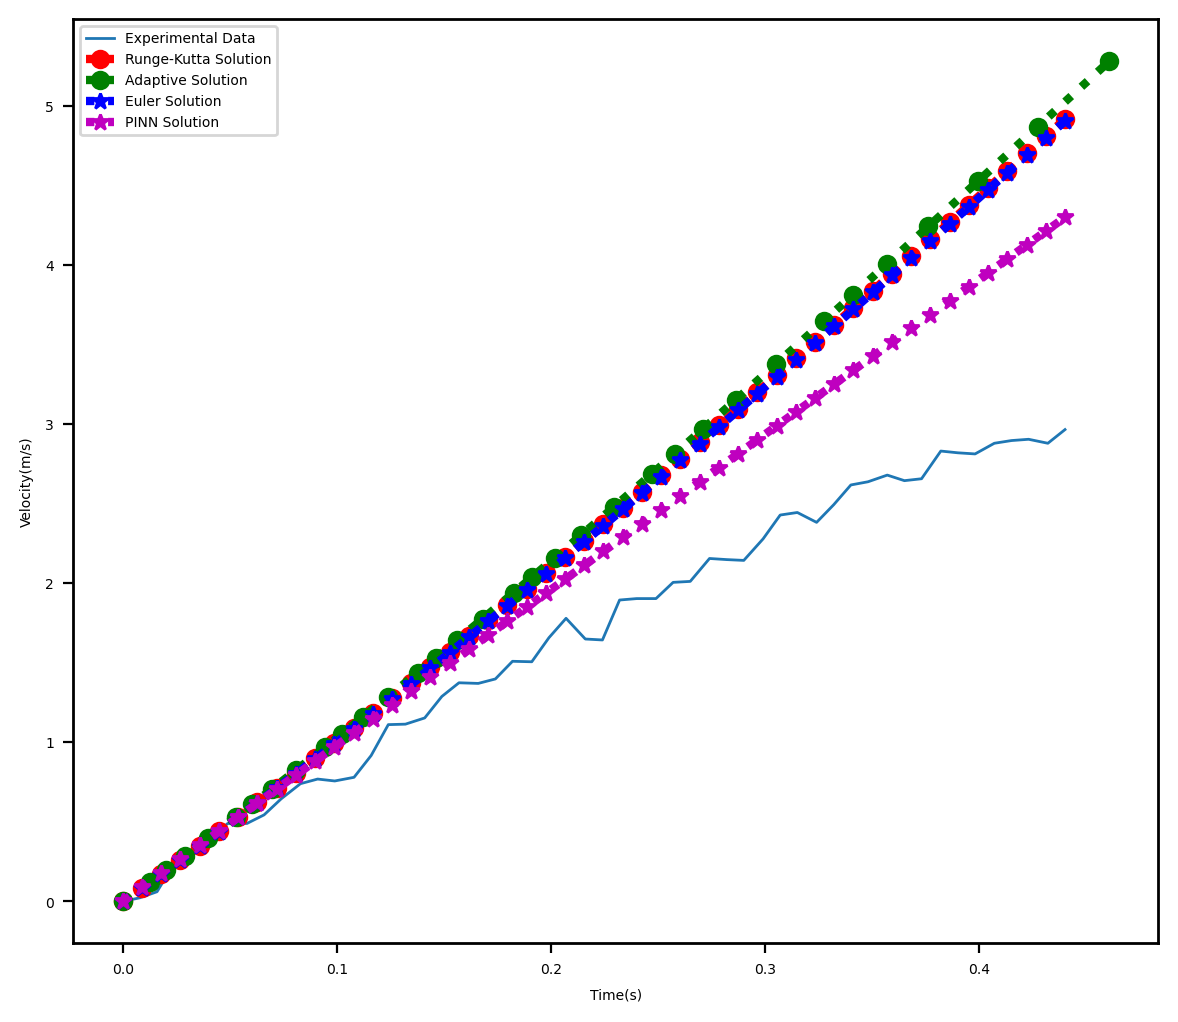

In [14]:
#plotting velocity
plt.plot(tdata,vxdata, label=r'Experimental Data')
plt.plot(rk4_solver[0],-rk4_solver[2],    ':ro' , linewidth=3.0,label=r'Runge-Kutta Solution')
plt.plot(adapt_solver[0],-adapt_solver[2],':go' , linewidth=3.0,label=r'Adaptive Solution')
plt.plot(euler_solver[0],-euler_solver[2],':b*' , linewidth=3.0,label=r'Euler Solution')
plt.plot(interp_func(pinn_data[:,0], pinn_data[:,1])[0], interp_func(pinn_data[:,0], pinn_data[:,1])[2],':m*' , linewidth=3.0,label=r'PINN Solution')
plt.xlabel('Time(s)')
plt.ylabel('Velocity(m/s)')
plt.legend()
plt.show()

In [15]:
print(interp_func(pinn_data[:,0], -pinn_data[:,1])[1])
print(interp_func(pinn_data[:,0], pinn_data[:,1])[2])

[ 0.00000000e+00 -3.88099045e-04 -1.56822243e-03 -3.54018899e-03
 -6.30381756e-03 -9.85892698e-03 -1.42053361e-02 -1.93428637e-02
 -2.52713287e-02 -3.19905498e-02 -3.95003460e-02 -4.78005360e-02
 -5.68909387e-02 -6.67713730e-02 -7.74416576e-02 -8.89016114e-02
 -1.01151053e-01 -1.14189802e-01 -1.28017676e-01 -1.42634495e-01
 -1.58040077e-01 -1.74234242e-01 -1.91216808e-01 -2.08987593e-01
 -2.27546417e-01 -2.46893099e-01 -2.67027457e-01 -2.87949310e-01
 -3.09658477e-01 -3.32154778e-01 -3.55438030e-01 -3.79508052e-01
 -4.04364664e-01 -4.30007684e-01 -4.56436931e-01 -4.83652224e-01
 -5.11653382e-01 -5.40440223e-01 -5.70012567e-01 -6.00370232e-01
 -6.31513037e-01 -6.63440801e-01 -6.96153343e-01 -7.29650481e-01
 -7.63932035e-01 -7.98997822e-01 -8.34847663e-01 -8.71481376e-01
 -9.08898780e-01 -9.47099693e-01]
[0.         0.0882128  0.17640542 0.26457787 0.35273014 0.44086224
 0.52897416 0.61706591 0.70513748 0.79318888 0.8812201  0.96923115
 1.05722202 1.14519271 1.23314323 1.32107358 1.40898

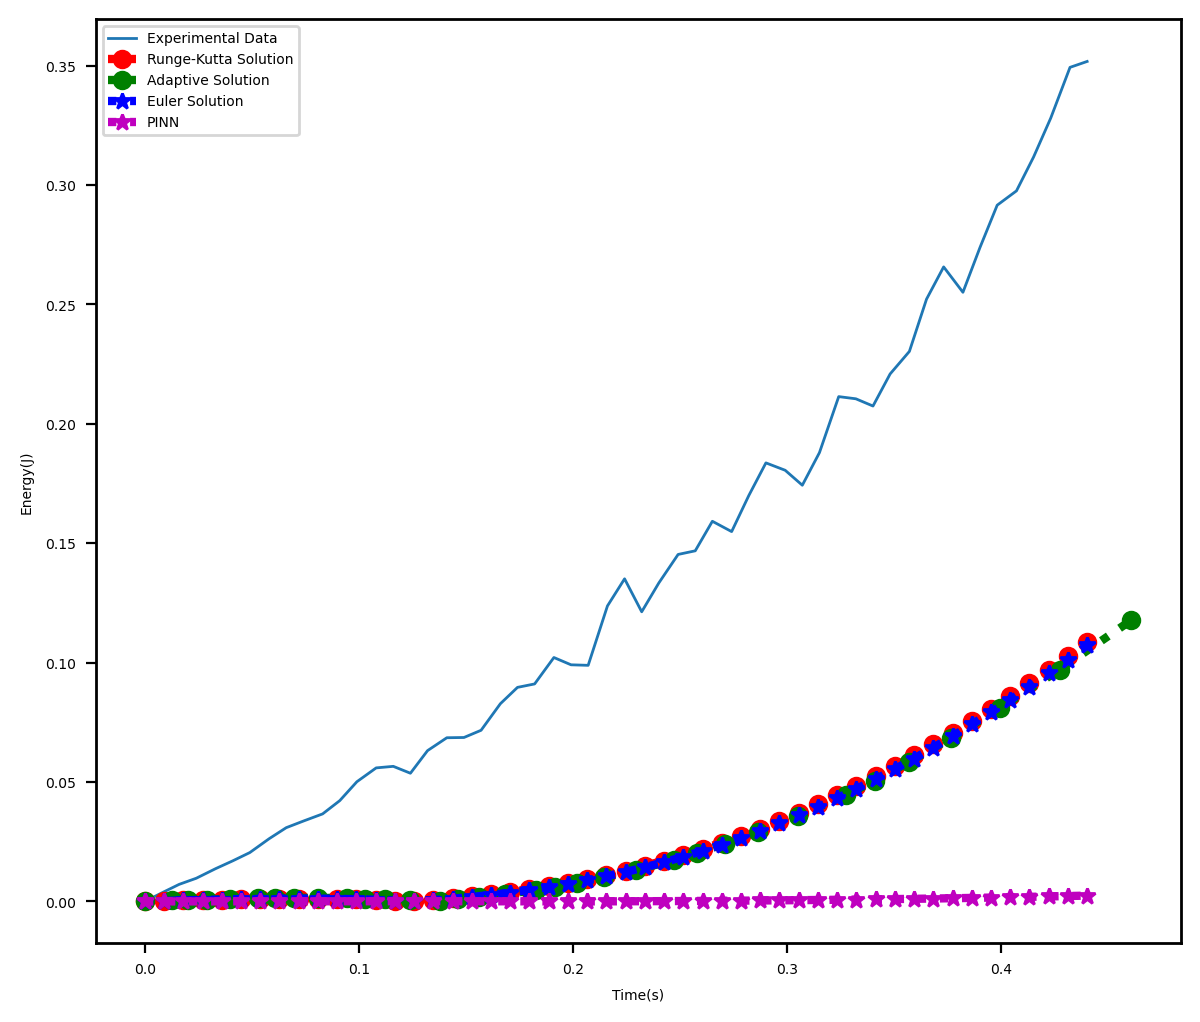

In [16]:
#Plotting Energy
plt.plot(tdata,E_trial1 ,label=r'Experimental Data')
plt.plot(rk4_solver[0], E_rk4,':ro' , linewidth=3.0, label=r'Runge-Kutta Solution')
plt.plot(adapt_solver[0], E_adapt,':go' , linewidth=3.0, label=r'Adaptive Solution')
plt.plot(euler_solver[0], E_euler,':b*' , linewidth=3.0, label=r'Euler Solution')
plt.plot(interp_func(pinn_data[:,0], pinn_data[:,1])[0], energy(mass, interp_func(pinn_data[:,0], -pinn_data[:,1])[1], interp_func(pinn_data[:,0], pinn_data[:,1])[2]), ':m*' , linewidth=3.0, label=r'PINN')
plt.xlabel('Time(s)')
plt.ylabel('Energy(J)')
plt.legend()
plt.show()

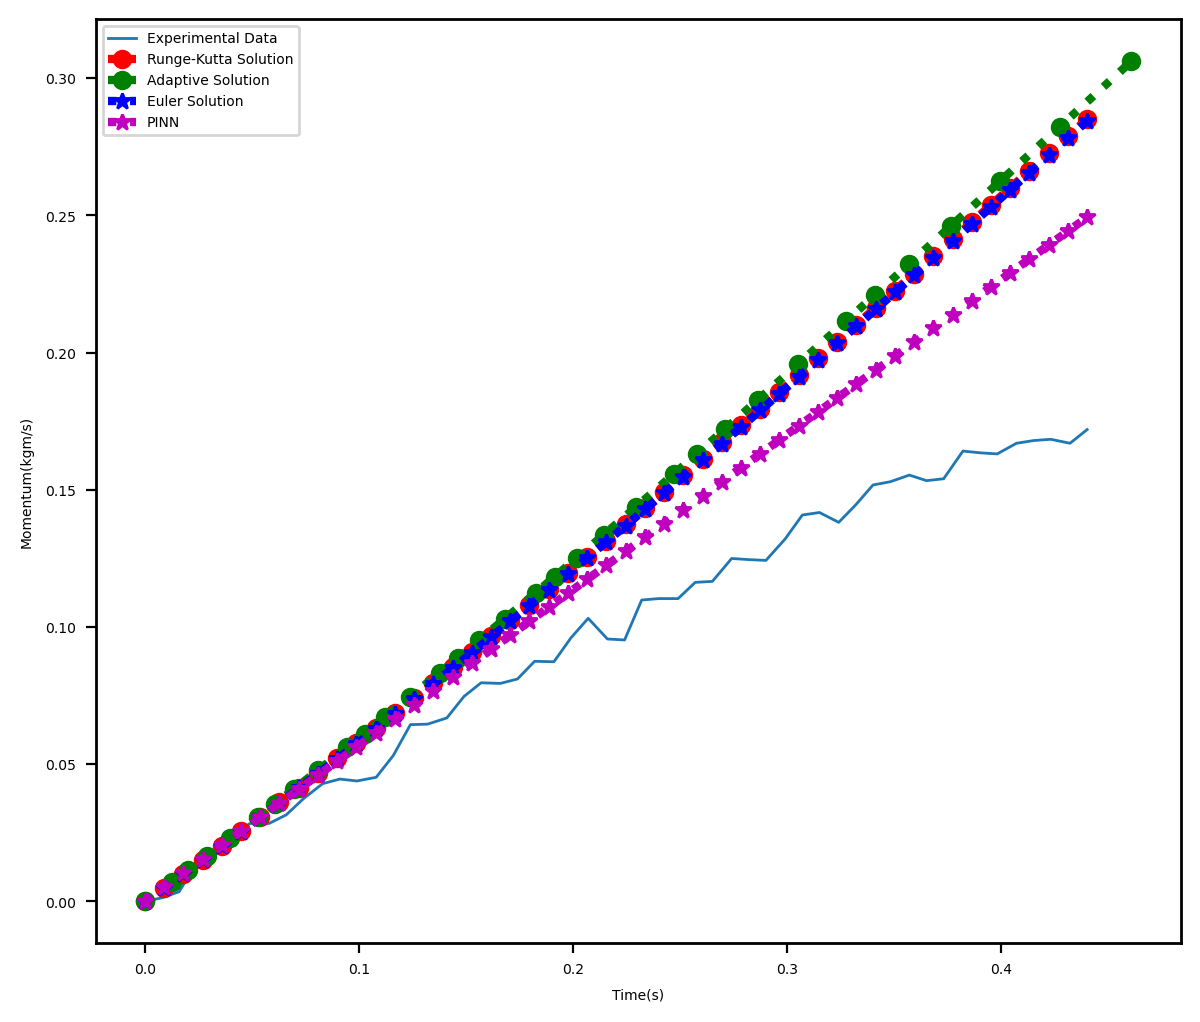

In [17]:
#Plotting Momentum
plt.plot(tdata,P_trial1, label=r'Experimental Data')
plt.plot(rk4_solver[0], P_rk4,':ro' , linewidth=3.0, label=r'Runge-Kutta Solution')
plt.plot(adapt_solver[0], P_adapt,':go' , linewidth=3.0, label=r'Adaptive Solution')
plt.plot(euler_solver[0], P_euler,':b*' , linewidth=3.0, label=r'Euler Solution')
plt.plot(interp_func(pinn_data[:,0], pinn_data[:,1])[0], momentum(mass, interp_func(pinn_data[:,0], pinn_data[:,1])[2]), ':m*' , linewidth=3.0, label=r'PINN')
plt.xlabel('Time(s)')
plt.ylabel('Momentum(kgm/s)')
plt.legend()
plt.show()


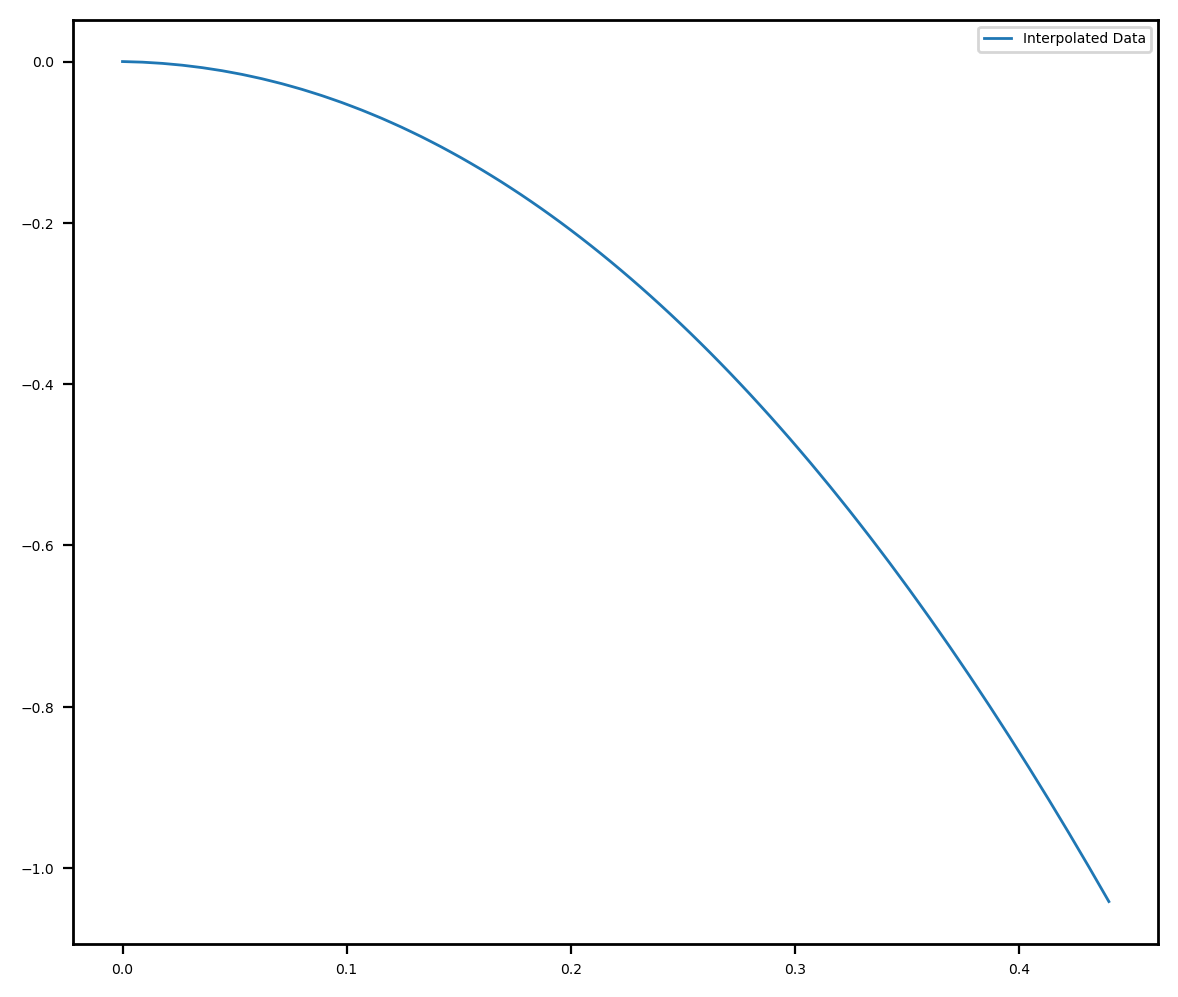

In [18]:
inter_rk4 = interp1d(rk4_solver[0], rk4_solver[1], kind='linear')
new_times = np.linspace(t0, tf, 100)           # Create new time points for interpolation
interpolated_positions = inter_rk4(new_times)  # Get interpolated positions at the new times
plt.plot(new_times, interpolated_positions, '-', label='Interpolated Data')  # Plot interpolated data
plt.legend()
plt.show()

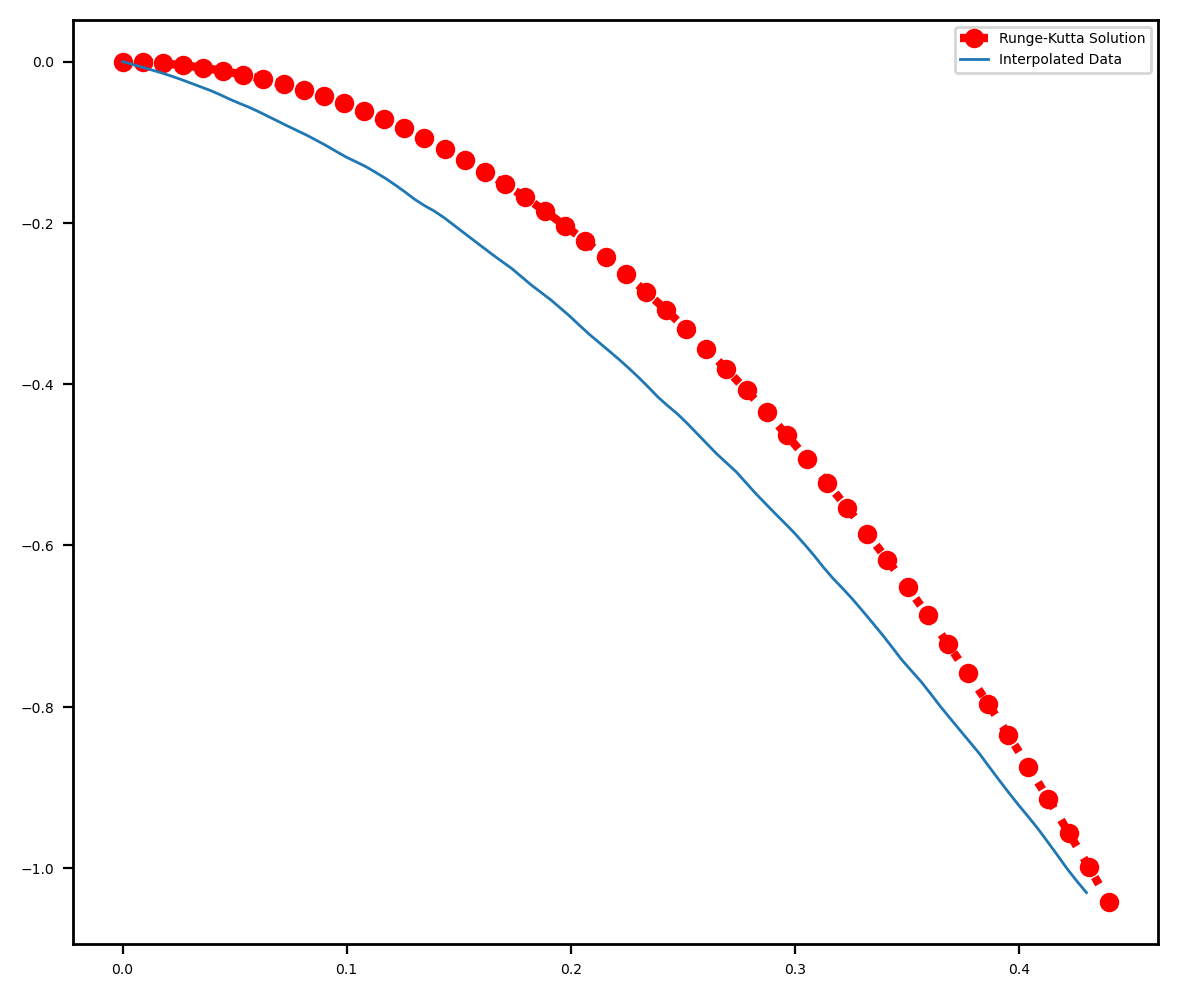

In [19]:
inter_data = interp1d(tdata, xdata, kind='linear')
new_times_data = np.linspace(t0, 0.43, 100)  # Create new time points for interpolation
interpolated_positions_data = inter_data(new_times_data)  # Get interpolated positions at the new times
plt.plot(rk4_solver[0],rk4_solver[1],    ':ro' , linewidth=3.0,label=r'Runge-Kutta Solution')
plt.plot(new_times_data, interpolated_positions_data, '-', label='Interpolated Data')  # Plot interpolated data
plt.legend()
plt.show()

In [20]:


# Assume tdata is your time data and xdata is your position data
position_spline = UnivariateSpline(tdata, -xdata, k=3)  # Using a cubic spline for smooth velocity estimation
velocity_function = position_spline.derivative()

# Calculate velocity at a specific time point
time_point = 0.25  # Example time
velocity_at_time_point = velocity_function(time_point)

# Calculate velocity at multiple time points
time_points = np.linspace(t0, tf, 50)  # Example time array
velocities = velocity_function(time_points)
shift_velocity=velocities-velocities[0]

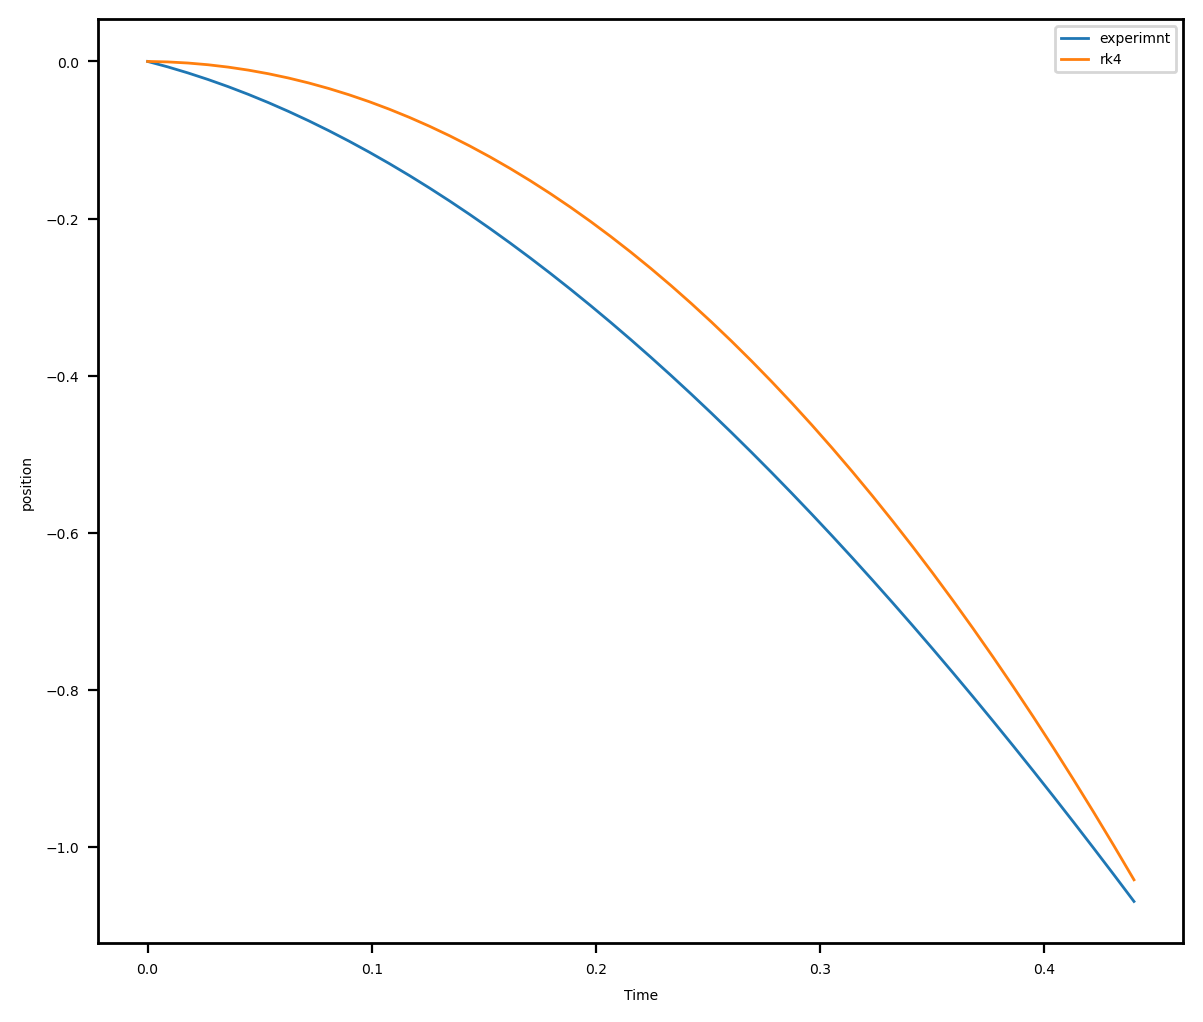

In [21]:
np.abs(interp_func(rk4_solver[0],rk4_solver[1])[3]-interp_func(tdata, -xdata)[3])
plt.plot(interp_func(tdata, xdata)[0],interp_func(tdata, xdata)[1], label='experimnt')
plt.plot(interp_func(rk4_solver[0],rk4_solver[1])[0], interp_func(rk4_solver[0],rk4_solver[1])[1], label='rk4')
plt.xlabel('Time')
plt.ylabel('position')
plt.legend()
plt.show()

In [22]:
interp_func(tdata, -xdata)

(array([0.        , 0.00897959, 0.01795918, 0.02693878, 0.03591837,
        0.04489796, 0.05387755, 0.06285714, 0.07183673, 0.08081633,
        0.08979592, 0.09877551, 0.1077551 , 0.11673469, 0.12571429,
        0.13469388, 0.14367347, 0.15265306, 0.16163265, 0.17061224,
        0.17959184, 0.18857143, 0.19755102, 0.20653061, 0.2155102 ,
        0.2244898 , 0.23346939, 0.24244898, 0.25142857, 0.26040816,
        0.26938776, 0.27836735, 0.28734694, 0.29632653, 0.30530612,
        0.31428571, 0.32326531, 0.3322449 , 0.34122449, 0.35020408,
        0.35918367, 0.36816327, 0.37714286, 0.38612245, 0.39510204,
        0.40408163, 0.41306122, 0.42204082, 0.43102041, 0.44      ]),
 array([0.        , 0.00692601, 0.0145855 , 0.02297127, 0.03207613,
        0.04189289, 0.05241436, 0.06363335, 0.07554265, 0.08813509,
        0.10140348, 0.11534061, 0.1299393 , 0.14519236, 0.16109259,
        0.1776328 , 0.19480581, 0.21260442, 0.23102144, 0.25004967,
        0.26968193, 0.28991102, 0.31072976, 0.

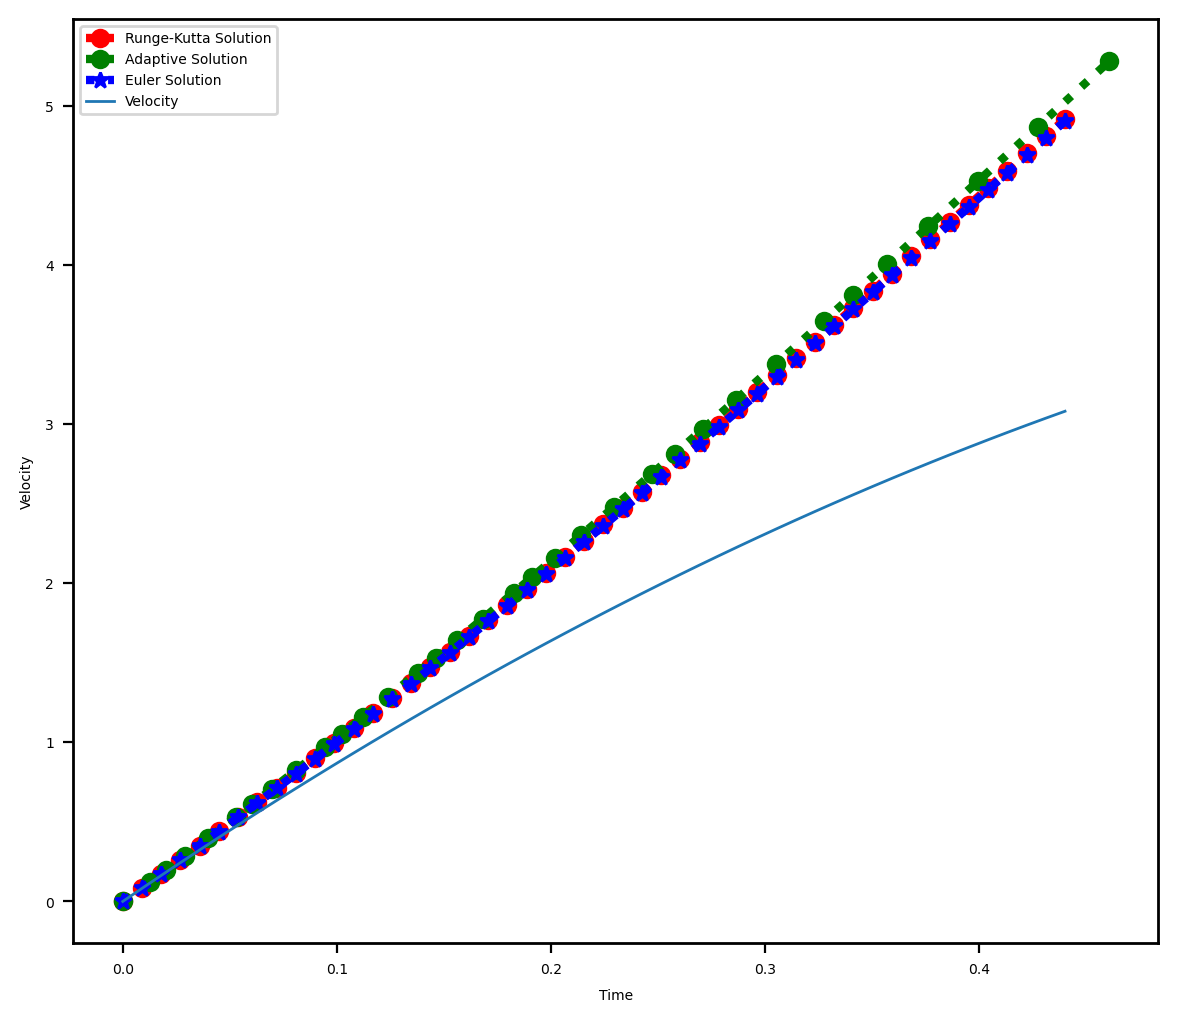

In [23]:
#plotting velocity
#plt.plot(tdata,vxdata, label=r'Experimental Data')
plt.plot(rk4_solver[0],-rk4_solver[2],    ':ro' , linewidth=3.0,label=r'Runge-Kutta Solution')
plt.plot(adapt_solver[0],-adapt_solver[2],':go' , linewidth=3.0,label=r'Adaptive Solution')
plt.plot(euler_solver[0],-euler_solver[2],':b*' , linewidth=3.0,label=r'Euler Solution')
plt.plot(time_points, interp_func(tdata, -xdata)[2], label='Velocity')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.legend()
plt.show()

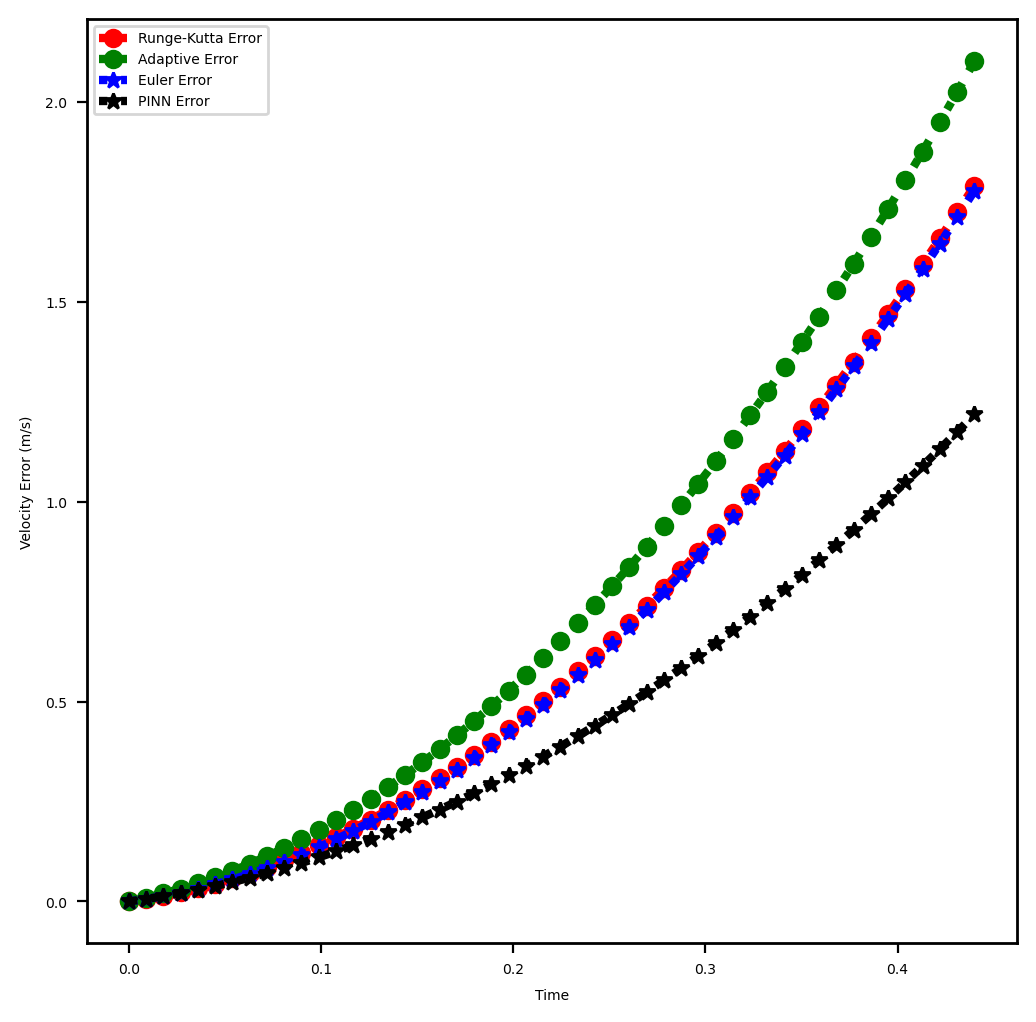

In [24]:
#Plotting velocity error
euler_error_v = np.abs(interp_func(tdata, xdata)[2]-interp_func(euler_solver[0], euler_solver[1])[2])
rk4_error_v = np.abs(interp_func(tdata, xdata)[2]-interp_func(rk4_solver[0], rk4_solver[1])[2])
adapt_errror_v = np.abs(interp_func(tdata, xdata)[2]-interp_func(adapt_solver[0], adapt_solver[1])[2])
pinn_error_v = np.abs(interp_func(tdata, xdata)[2]-interp_func(pinn_data[:,0], -pinn_data[:,1])[2])

plt.figure(figsize=(6,6))
plt.plot(interp_func(tdata, xdata)[0],rk4_error_v,':ro' , linewidth=3.0,label=r'Runge-Kutta Error')
plt.plot(interp_func(tdata, xdata)[0],adapt_errror_v,':go' , linewidth=3.0,label=r'Adaptive Error')
plt.plot(interp_func(tdata, xdata)[0],euler_error_v,':b*' , linewidth=3.0,label=r'Euler Error')
plt.plot(interp_func(tdata, xdata)[0],pinn_error_v,':k*' , linewidth=3.0,label=r'PINN Error')

plt.xlabel('Time')
plt.ylabel('Velocity Error (m/s)')
plt.legend()
plt.show()

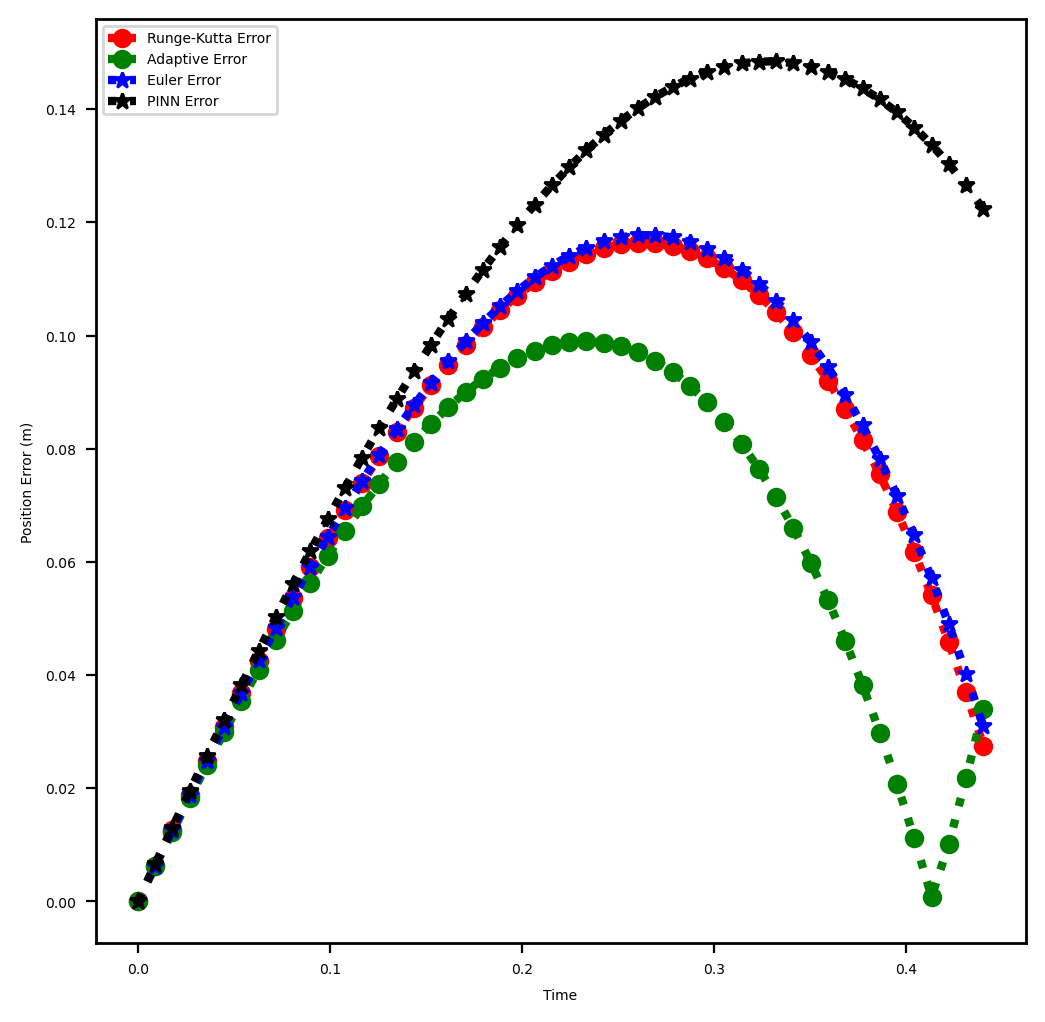

In [25]:
#Plotting position error
euler_error_y = np.abs(interp_func(tdata, xdata)[1]-interp_func(euler_solver[0], euler_solver[1])[1])
rk4_error_y = np.abs(interp_func(tdata, xdata)[1]-interp_func(rk4_solver[0], rk4_solver[1])[1])
adapt_errror_y = np.abs(interp_func(tdata, xdata)[1]-interp_func(adapt_solver[0], adapt_solver[1])[1])
pinn_error_y = np.abs(interp_func(tdata, xdata)[1]-interp_func(pinn_data[:,0], -pinn_data[:,1])[1])

plt.figure(figsize=(6,6))
plt.plot(interp_func(tdata, xdata)[0],rk4_error_y,':ro' , linewidth=3.0,label=r'Runge-Kutta Error')
plt.plot(interp_func(tdata, xdata)[0],adapt_errror_y,':go' , linewidth=3.0,label=r'Adaptive Error')
plt.plot(interp_func(tdata, xdata)[0],euler_error_y,':b*' , linewidth=3.0,label=r'Euler Error')
plt.plot(interp_func(tdata, xdata)[0],pinn_error_y,':k*' , linewidth=3.0,label=r'PINN Error')

plt.xlabel('Time')
plt.ylabel('Position Error (m)')
plt.legend()
plt.show()

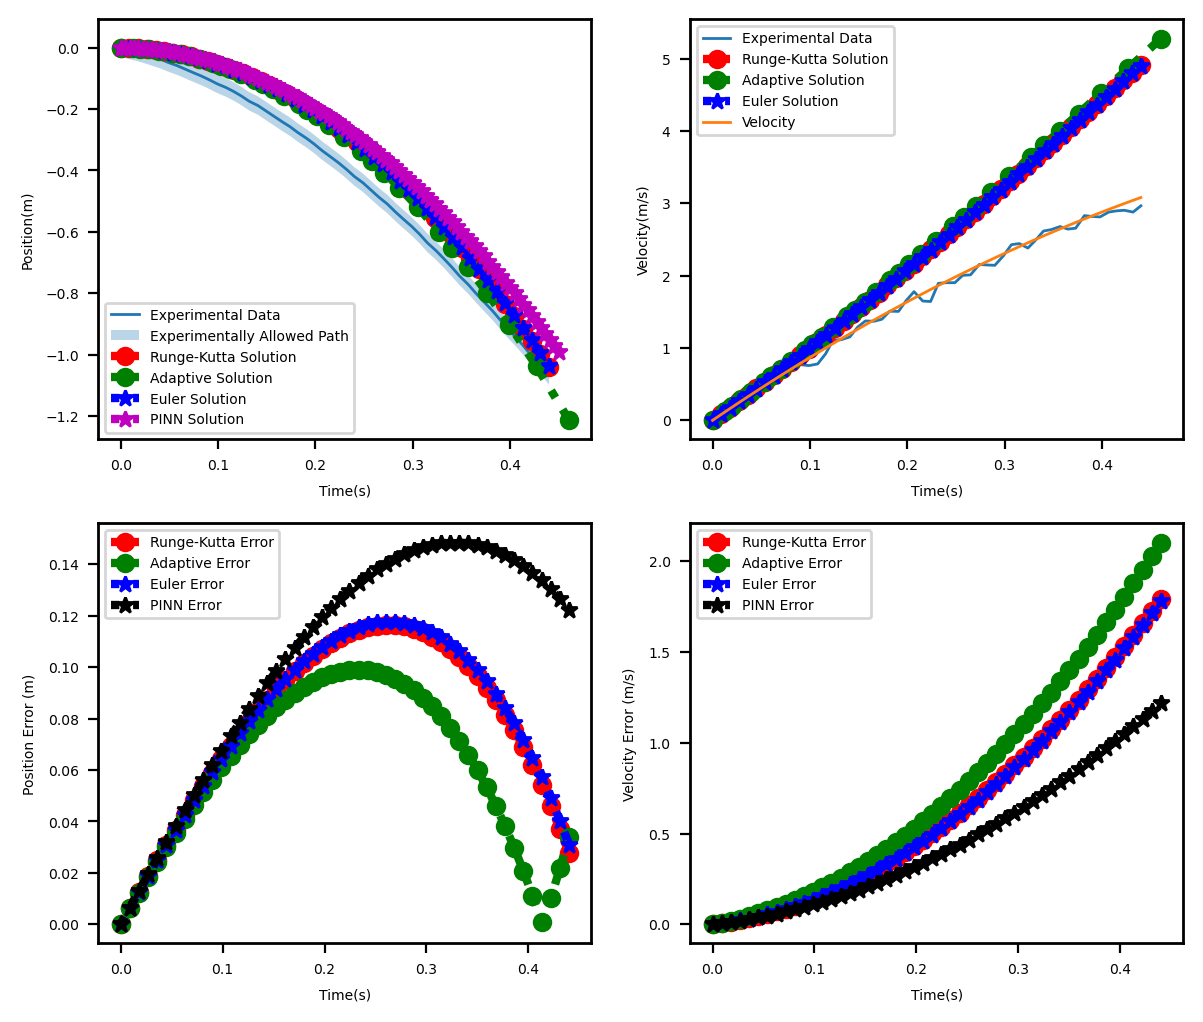

In [26]:
fig, axs = plt.subplots(2, 2)
ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]
ax4 = axs[1, 1]

# Plot for position
ax1.plot(tdata,xdata, label=r'Experimental Data')
ax1.fill_between(tdata, xdata_upr, xdata_lwr,    alpha=0.3,    label="Experimentally Allowed Path")
ax1.plot(rk4_solver[0],rk4_solver[1],    ':ro' , linewidth=3.0,label=r'Runge-Kutta Solution')
ax1.plot(adapt_solver[0],adapt_solver[1],':go' , linewidth=3.0,label=r'Adaptive Solution')
ax1.plot(euler_solver[0],euler_solver[1],':b*' , linewidth=3.0,label=r'Euler Solution')
ax1.plot(pinn_data[:,0],-pinn_data[:,1],':m*' , linewidth=3.0,label=r'PINN Solution')
ax1.set_xlabel('Time(s)')
ax1.set_ylabel('Position(m)')
ax1.legend()

ax2.plot(tdata,vxdata, label=r'Experimental Data')
ax2.plot(rk4_solver[0],-rk4_solver[2],    ':ro' , linewidth=3.0,label=r'Runge-Kutta Solution')
ax2.plot(adapt_solver[0],-adapt_solver[2],':go' , linewidth=3.0,label=r'Adaptive Solution')
ax2.plot(euler_solver[0],-euler_solver[2],':b*' , linewidth=3.0,label=r'Euler Solution')
ax2.plot(time_points, interp_func(tdata, -xdata)[2], label='Velocity')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Velocity(m/s)')
ax2.legend()



ax3.plot(interp_func(tdata, xdata)[0],rk4_error_y,':ro' , linewidth=3.0,label=r'Runge-Kutta Error')
ax3.plot(interp_func(tdata, xdata)[0],adapt_errror_y,':go' , linewidth=3.0,label=r'Adaptive Error')
ax3.plot(interp_func(tdata, xdata)[0],euler_error_y,':b*' , linewidth=3.0,label=r'Euler Error')
ax3.plot(interp_func(tdata, xdata)[0],pinn_error_y,':k*' , linewidth=3.0,label=r'PINN Error')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Position Error (m)')
ax3.legend()

#
ax4.plot(interp_func(tdata, xdata)[0],rk4_error_v,':ro' , linewidth=3.0,label=r'Runge-Kutta Error')
ax4.plot(interp_func(tdata, xdata)[0],adapt_errror_v,':go' , linewidth=3.0,label=r'Adaptive Error')
ax4.plot(interp_func(tdata, xdata)[0],euler_error_v,':b*' , linewidth=3.0,label=r'Euler Error')
ax4.plot(interp_func(tdata, xdata)[0],pinn_error_v,':k*' , linewidth=3.0,label=r'PINN Error')
ax4.set_xlabel('Time(s)')
ax4.set_ylabel('Velocity Error (m/s)')
ax4.legend()

plt.show()

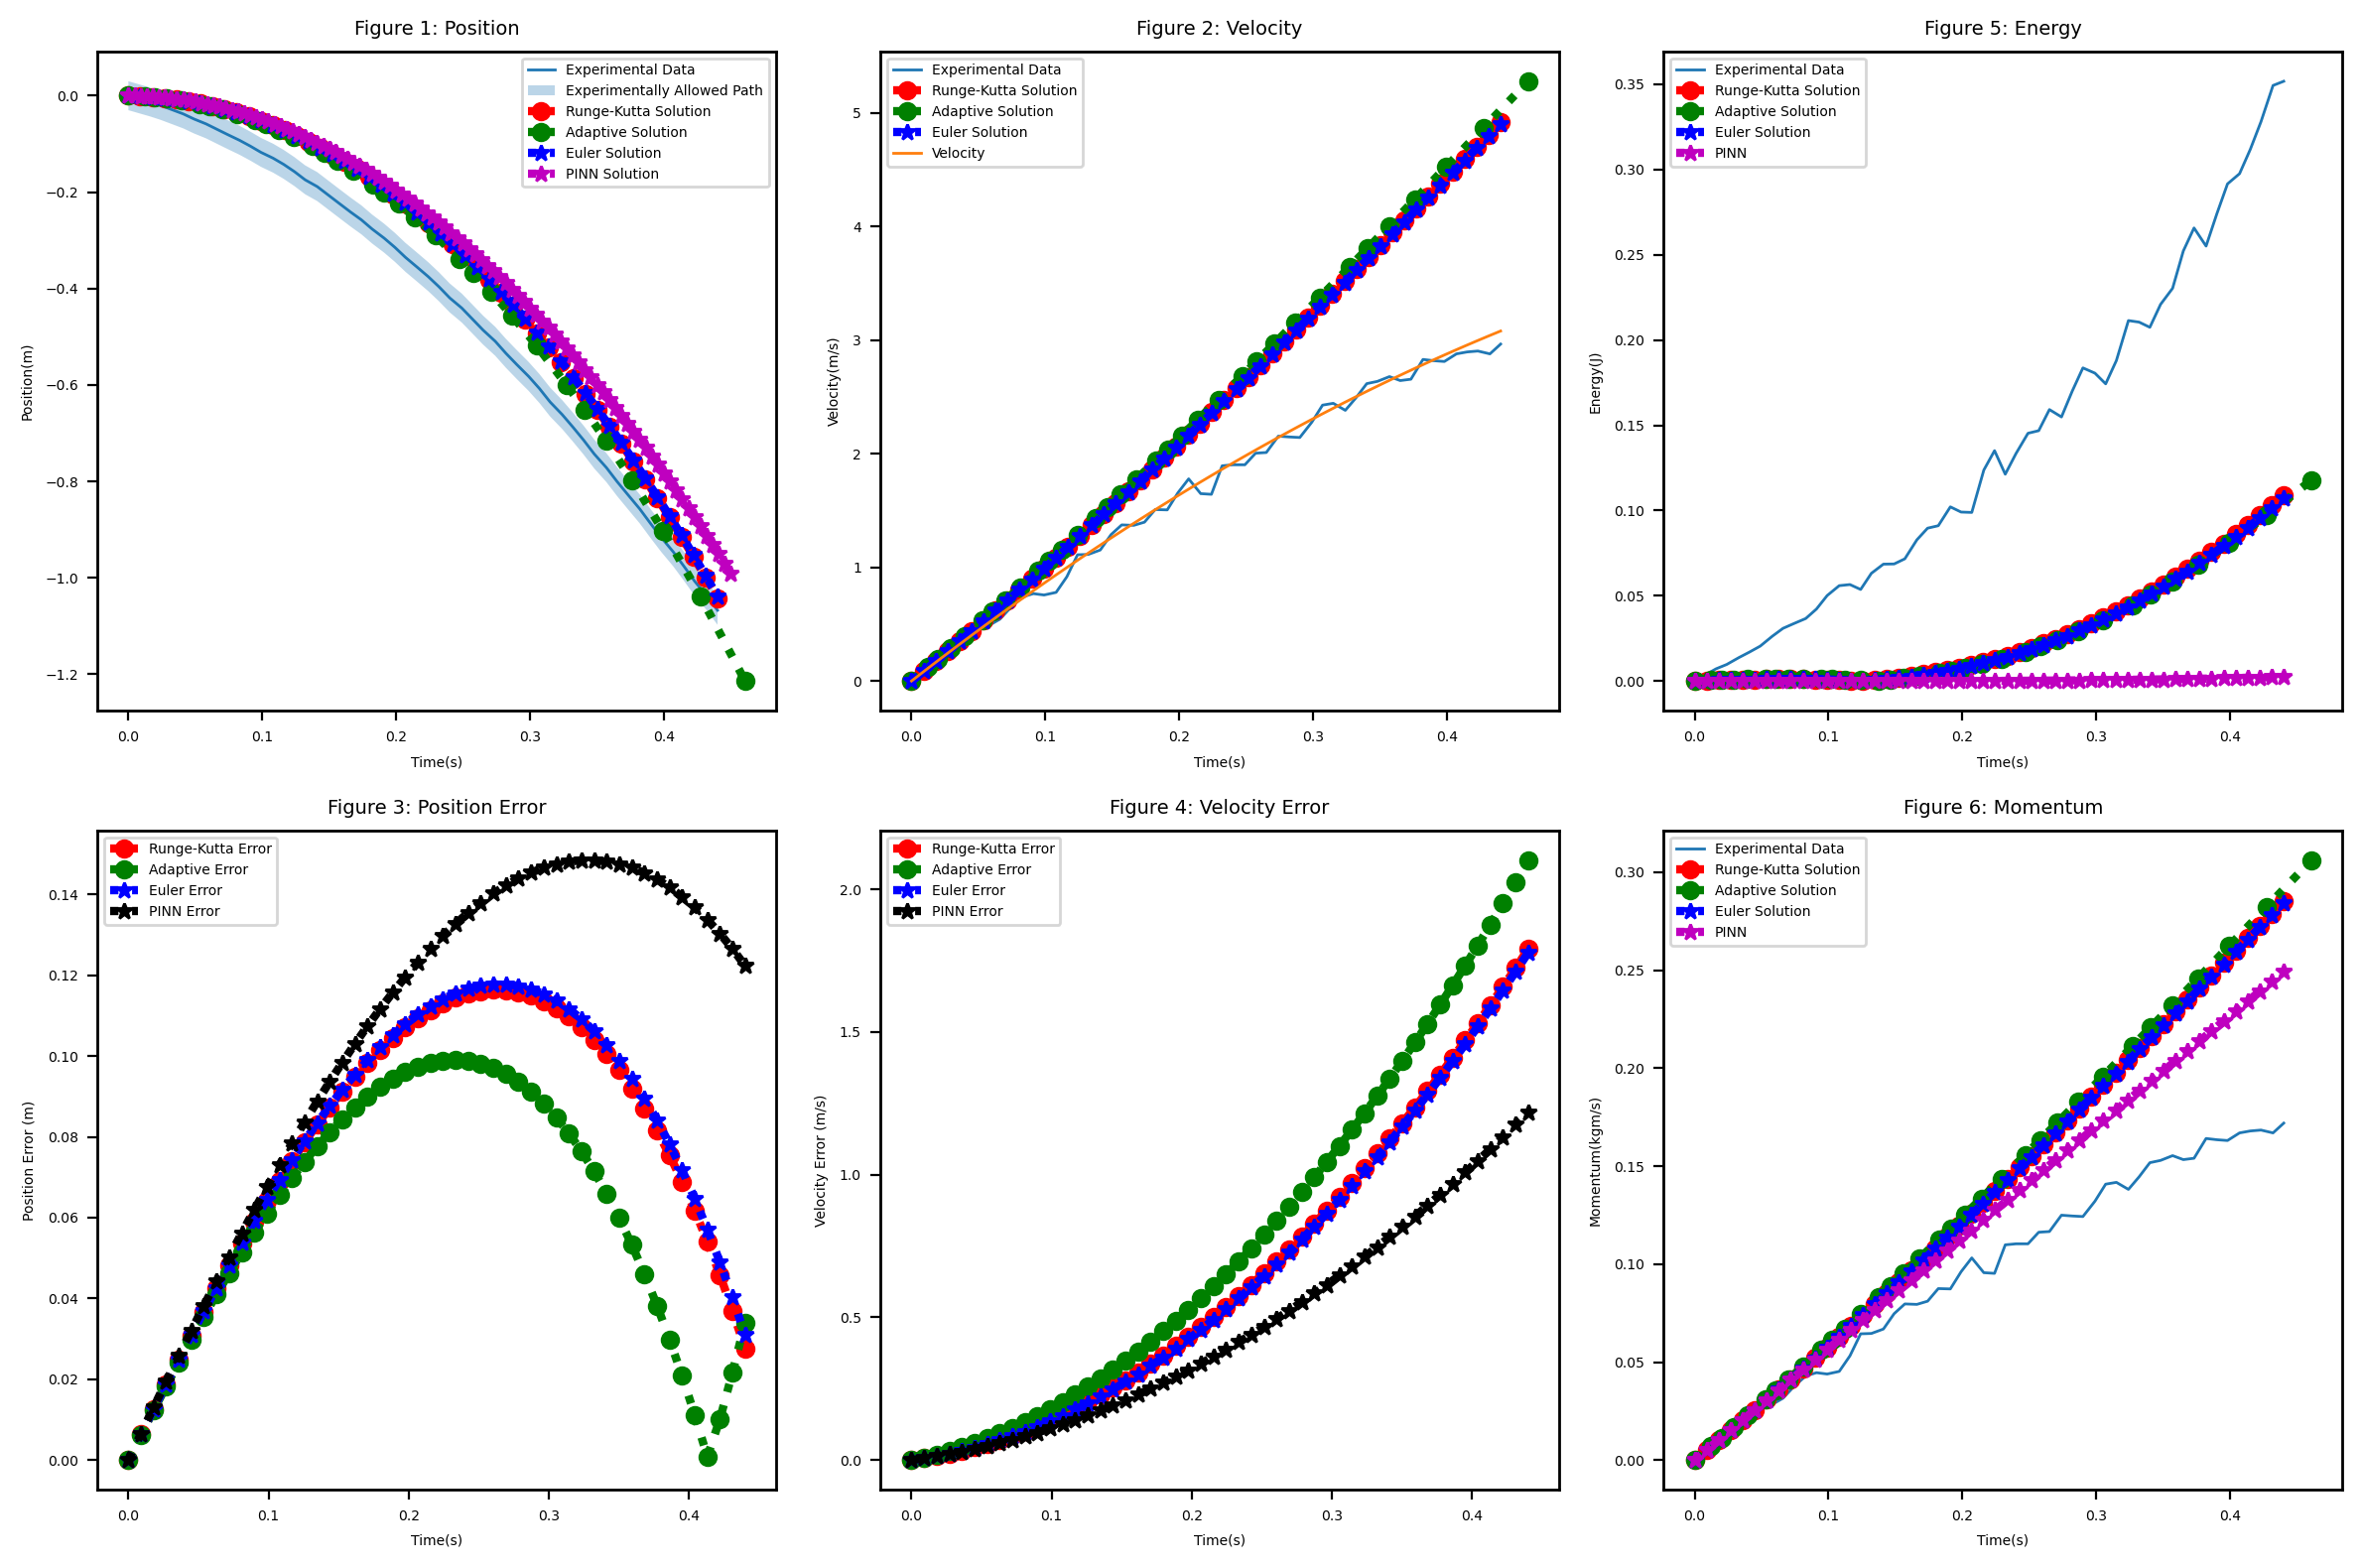

In [27]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create a 2x3 grid
fig = plt.figure(figsize=(12, 8))  # Adjust figure size as needed
gs = gridspec.GridSpec(2, 3, figure=fig)

# Assign axes to grid positions
ax1 = fig.add_subplot(gs[0, 0])  # Position (row 0, column 0)
ax2 = fig.add_subplot(gs[0, 1])  # Position (row 0, column 1)
ax3 = fig.add_subplot(gs[1, 0])  # Position (row 1, column 0)
ax4 = fig.add_subplot(gs[1, 1])  # Position (row 1, column 1)
ax5 = fig.add_subplot(gs[0, 2])  # Position (row 0, column 2) for energy
ax6 = fig.add_subplot(gs[1, 2])  # Position (row 1, column 2) for momentum


# Plot position on ax1
ax1.set_title('Figure 1: Position')
ax1.plot(tdata,xdata, label=r'Experimental Data')
ax1.fill_between(tdata, xdata_upr, xdata_lwr,    alpha=0.3,    label="Experimentally Allowed Path")
ax1.plot(rk4_solver[0],rk4_solver[1],    ':ro' , linewidth=3.0,label=r'Runge-Kutta Solution')
ax1.plot(adapt_solver[0],adapt_solver[1],':go' , linewidth=3.0,label=r'Adaptive Solution')
ax1.plot(euler_solver[0],euler_solver[1],':b*' , linewidth=3.0,label=r'Euler Solution')
ax1.plot(pinn_data[:,0],-pinn_data[:,1],':m*' , linewidth=3.0,label=r'PINN Solution')
ax1.set_xlabel('Time(s)')
ax1.set_ylabel('Position(m)')
ax1.legend()

# Plot velocity on ax2
ax2.set_title('Figure 2: Velocity')
ax2.plot(tdata,vxdata, label=r'Experimental Data')
ax2.plot(rk4_solver[0],-rk4_solver[2],    ':ro' , linewidth=3.0,label=r'Runge-Kutta Solution')
ax2.plot(adapt_solver[0],-adapt_solver[2],':go' , linewidth=3.0,label=r'Adaptive Solution')
ax2.plot(euler_solver[0],-euler_solver[2],':b*' , linewidth=3.0,label=r'Euler Solution')
ax2.plot(time_points, interp_func(tdata, -xdata)[2], label='Velocity')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Velocity(m/s)')
ax2.legend()

# Plot position error on ax3
ax3.set_title('Figure 3: Position Error')
ax3.plot(interp_func(tdata, xdata)[0],rk4_error_y,':ro' , linewidth=3.0,label=r'Runge-Kutta Error')
ax3.plot(interp_func(tdata, xdata)[0],adapt_errror_y,':go' , linewidth=3.0,label=r'Adaptive Error')
ax3.plot(interp_func(tdata, xdata)[0],euler_error_y,':b*' , linewidth=3.0,label=r'Euler Error')
ax3.plot(interp_func(tdata, xdata)[0],pinn_error_y,':k*' , linewidth=3.0,label=r'PINN Error')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Position Error (m)')
ax3.legend()

# Plot velocity error on ax4
ax4.set_title('Figure 4: Velocity Error')
ax4.plot(interp_func(tdata, xdata)[0],rk4_error_v,':ro' , linewidth=3.0,label=r'Runge-Kutta Error')
ax4.plot(interp_func(tdata, xdata)[0],adapt_errror_v,':go' , linewidth=3.0,label=r'Adaptive Error')
ax4.plot(interp_func(tdata, xdata)[0],euler_error_v,':b*' , linewidth=3.0,label=r'Euler Error')
ax4.plot(interp_func(tdata, xdata)[0],pinn_error_v,':k*' , linewidth=3.0,label=r'PINN Error')
ax4.set_xlabel('Time(s)')
ax4.set_ylabel('Velocity Error (m/s)')
ax4.legend()

# Plot energy on ax5
ax5.set_title('Figure 5: Energy')
ax5.plot(tdata,E_trial1 ,label=r'Experimental Data')
ax5.plot(rk4_solver[0], E_rk4,':ro' , linewidth=3.0, label=r'Runge-Kutta Solution')
ax5.plot(adapt_solver[0], E_adapt,':go' , linewidth=3.0, label=r'Adaptive Solution')
ax5.plot(euler_solver[0], E_euler,':b*' , linewidth=3.0, label=r'Euler Solution')
ax5.plot(interp_func(pinn_data[:,0], pinn_data[:,1])[0], energy(mass, interp_func(pinn_data[:,0], -pinn_data[:,1])[1], interp_func(pinn_data[:,0], pinn_data[:,1])[2]), ':m*' , linewidth=3.0, label=r'PINN')
ax5.set_xlabel('Time(s)')
ax5.set_ylabel('Energy(J)')
ax5.legend()

# Plot momentum on ax6
ax6.set_title('Figure 6: Momentum')
ax6.plot(tdata,P_trial1, label=r'Experimental Data')
ax6.plot(rk4_solver[0], P_rk4,':ro' , linewidth=3.0, label=r'Runge-Kutta Solution')
ax6.plot(adapt_solver[0], P_adapt,':go' , linewidth=3.0, label=r'Adaptive Solution')
ax6.plot(euler_solver[0], P_euler,':b*' , linewidth=3.0, label=r'Euler Solution')
ax6.plot(interp_func(pinn_data[:,0], pinn_data[:,1])[0], momentum(mass, interp_func(pinn_data[:,0], pinn_data[:,1])[2]), ':m*' , linewidth=3.0, label=r'PINN')
ax6.set_xlabel('Time(s)')
ax6.set_ylabel('Momentum(kgm/s)')
ax6.legend()

plt.tight_layout()  # Adjust spacing between subplots
plt.show()